Importing the necessary libraries

In [1]:
import requests
import pandas as pd
from io import BytesIO
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats
from tqdm.auto import tqdm

%matplotlib inline
plt.style.use('ggplot')

Loading our data

In [2]:
def get_data(public_key):
    base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'

    # Get the download link
    final_url = base_url + 'public_key=' + public_key
    response = requests.get(final_url)
    download_url = response.json()['href']
    req = requests.get(download_url)
    data = req.content

    df = pd.read_csv(BytesIO(data), sep=';')
    return df

In [3]:
users_test = 'https://disk.yandex.ru/d/4XXIME4osGrMRA'
users_control_1 = 'https://disk.yandex.ru/d/yJFydMNNGkEKfg'
users_control_2 = 'https://disk.yandex.ru/d/br6KkQupzzTGoQ'
transactions_test = 'https://disk.yandex.ru/d/gvCWpZ55ODzs2g'
transactions_control_1 = 'https://disk.yandex.ru/d/VY5W0keMX5TZBQ'
transactions_control_2 = 'https://disk.yandex.ru/d/th5GL0mGOc-qzg'
u_test = get_data(users_test)
u_1 = get_data(users_control_1)
u_2 = get_data(users_control_2)
t_test = get_data(transactions_test)
t_1 = get_data(transactions_control_1)
t_2 = get_data(transactions_control_2)

In [4]:
print(u_test.info(), u_1.info(), u_2.info(), t_test.info(), t_1.info(), t_2.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4308 entries, 0 to 4307
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   uid               4308 non-null   int64  
 1   age               4308 non-null   int64  
 2   attraction_coeff  4308 non-null   int64  
 3   coins             49 non-null     float64
 4   country           4308 non-null   object 
 5   visit_days        2978 non-null   object 
 6   gender            4308 non-null   int64  
 7   age_filter_start  4308 non-null   int64  
 8   age_filter_end    4308 non-null   int64  
 9   views_count       4308 non-null   int64  
 10  was_premium       408 non-null    float64
 11  is_premium        157 non-null    float64
 12  total_revenue     4308 non-null   int64  
dtypes: float64(3), int64(8), object(2)
memory usage: 437.7+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4340 entries, 0 to 4339
Data columns (total 13 columns):
 #   Column      

We see a lot of missing values. Transactions in the first control group contain extra blank lines. Let's delete them and insert 0 instead of the remaining gaps.

In [5]:
t_1 = t_1.dropna()

In [6]:
u_test = u_test.fillna(0)
u_1 = u_1.fillna(0)
u_2 = u_2.fillna(0)

Let's change the data types to more suitable ones.

In [7]:
t_1[['uid', 'revenue', 'payment_id']] = t_1[['uid', 'revenue', 'payment_id']].astype(int)
u_test[['is_premium', 'was_premium']] = u_test[['is_premium', 'was_premium']].astype(int)
u_1[['is_premium', 'was_premium']] = u_1[['is_premium', 'was_premium']].astype(int)
u_2[['is_premium', 'was_premium']] = u_2[['is_premium', 'was_premium']].astype(int)
t_test[['joined_at', 'paid_at']] = t_test[['joined_at', 'paid_at']].apply(pd.to_datetime)
t_1[['joined_at', 'paid_at']] = t_1[['joined_at', 'paid_at']].apply(pd.to_datetime)
t_2[['joined_at', 'paid_at']] = t_2[['joined_at', 'paid_at']].apply(pd.to_datetime)

Let's compare the groups with each other according to time periods.

In [8]:
print(t_test['joined_at'].min(), t_test['joined_at'].max())
print(t_1['joined_at'].min(), t_1['joined_at'].max())
print(t_2['joined_at'].min(), t_2['joined_at'].max())

2017-01-11 03:07:00 2017-10-31 23:40:00
2015-01-19 11:49:00 2017-10-31 22:17:00
2017-01-11 08:36:00 2017-10-31 17:43:00


The first control group contains strange transactions for 2015. Let's take a closer look at them:

In [9]:
t_1.query('joined_at < "2017-01-11"')

,uid,country,joined_at,paid_at,revenue,payment_id,from_page,product_type
65,960936960,Russian Federation,2015-01-19 11:49:00,2016-12-14 17:30:00,26,0,refund_VP,other_type
101,960936960,Russian Federation,2015-01-19 11:49:00,2016-12-14 17:35:00,637,0,refung_AP,other_type
224,960936960,Russian Federation,2015-01-19 11:49:00,2016-12-14 16:16:00,143,0,refund_WP,other_type


In [10]:
u_1.query('uid == 960936960')

,uid,age,attraction_coeff,coins,country,visit_days,gender,age_filter_start,age_filter_end,views_count,was_premium,is_premium,total_revenue
510,960936960,30,4,99958.0,Russian Federation,"1,2,3,4,7,8,9,10,11,14,15,16,17,18,21,22,23,24...",1,26,62,4262,1,1,26


For the purity of the experiment, our data must be taken for the same time periods, so we will remove this user from our dataframes.

In [11]:
u_1 = u_1.loc[u_1['uid'] != 960936960].copy()
t_1 = t_1.loc[t_1['uid'] != 960936960].copy()

Let's see if the data of users and their transactions matches:

In [12]:
print(
    u_test.total_revenue.sum() == t_test.revenue.sum(),
    u_1.total_revenue.sum() == t_1.revenue.sum(),
    u_2.total_revenue.sum() == t_2.revenue.sum()
)

False False True


The data doesn’t add up, let’s take a closer look:

In [13]:
revenue_test = t_test.groupby('uid').revenue.sum().reset_index()
u_test_r = u_test.merge(revenue_test, on='uid', how='left')
u_test_r[(u_test_r.total_revenue != u_test_r.revenue) & (u_test_r.revenue >0)]

,uid,age,attraction_coeff,coins,country,visit_days,gender,age_filter_start,age_filter_end,views_count,was_premium,is_premium,total_revenue,revenue
2070,892275462,31,310,0.0,France,"1,2,3,4,5,9,13,15,16",1,36,68,58,1,1,14885,58968.0


In [14]:
t_test.query('uid == 892275462')

,uid,country,joined_at,paid_at,revenue,payment_id,from_page,product_type
64,892275462,France,2017-10-17 05:56:00,2017-02-11 18:24:00,44083,19,coins_popup,other_type
154,892275462,France,2017-10-17 05:56:00,2017-10-20 17:00:00,14885,68,super_popup,other_type


We see that one of the transactions was not taken into account in the table with users. Let's change the total_revenue value for this user.

In [15]:
u_test.loc[u_test['uid'] == 892275462, 'total_revenue'] = 58968
u_test.total_revenue.sum() == t_test.revenue.sum()

True

Let's do the same operation with the first control group.

In [16]:
revenue_1= t_1.groupby('uid').revenue.sum().reset_index()
u_1_r = u_1.merge(revenue_1, on='uid', how='left')
u_1_r[(u_1_r.total_revenue != u_1_r.revenue) & (u_1_r.revenue >0)]

,uid,age,attraction_coeff,coins,country,visit_days,gender,age_filter_start,age_filter_end,views_count,was_premium,is_premium,total_revenue,revenue
3369,892355163,40,640,0.0,United States of America,"1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,1...",1,25,60,700,1,0,0,30264.0


In [17]:
t_1.query('uid == 892355163')

,uid,country,joined_at,paid_at,revenue,payment_id,from_page,product_type
303,892355163,United States of America,2017-10-15 18:45:00,2017-10-16 09:52:00,30264,68,super_popup,other_type


In [18]:
u_1.loc[u_1['uid'] == 892355163, 'total_revenue'] = 30264
u_1.total_revenue.sum() == t_1.revenue.sum()

True

Let's look for duplicates.

In [19]:
print(u_test.duplicated().sum(),
      u_1.duplicated().sum(), 
      u_2.duplicated().sum(),
      t_test.duplicated().sum(),
      t_1.duplicated().sum(),
      t_2.duplicated().sum(), sep='\n')

0
0
0
7
21
5


In [20]:
t_2[t_2.duplicated()]

,uid,country,joined_at,paid_at,revenue,payment_id,from_page,product_type
86,891862596,Italy,2017-10-26 01:40:00,2017-10-30 09:01:00,1261,19,empty_likes,coins
235,892064328,United States of America,2017-10-21 20:54:00,2017-10-22 01:30:00,6305,19,empty_likes,coins
241,892009254,Italy,2017-10-22 22:57:00,2017-10-23 00:06:00,2353,67,empty_likes,other_type
288,892062660,United States of America,2017-10-21 21:28:00,2017-10-31 00:53:00,1261,19,empty_likes,coins
321,892045743,Israel,2017-10-22 07:04:00,2017-10-23 20:17:00,1261,19,empty_likes,coins


Duplicates are present in the transaction dataframes; however, since the revenue of users and transactions align, everything is likely in order. It's possible that duplicates arise because seconds are not accounted for in the transaction times.


We have cleaned our data and brought it into a consistent form. We can move on

## A/A - test

Let's move on to the A/A test. We will evaluate the quality of the splitting system by checking the FPR (False Positive Rate) of our key business metrics

Let's take ARPU and conversion as key metrics. Since the experiment consisted of changing the cost of a premium subscription, we will count the purchase of a premium subscription as a conversion without taking into account trial subscriptions.
First, let's take a look at the distribution of revenue by user:

In [21]:
np.isinf(u_1.total_revenue).sum()

0

In [22]:
print(sns.__version__)

0.13.2


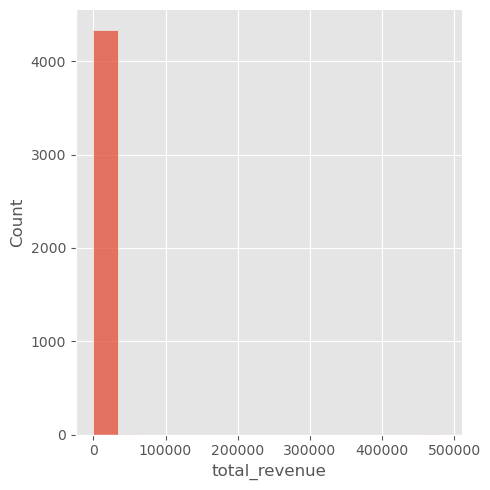

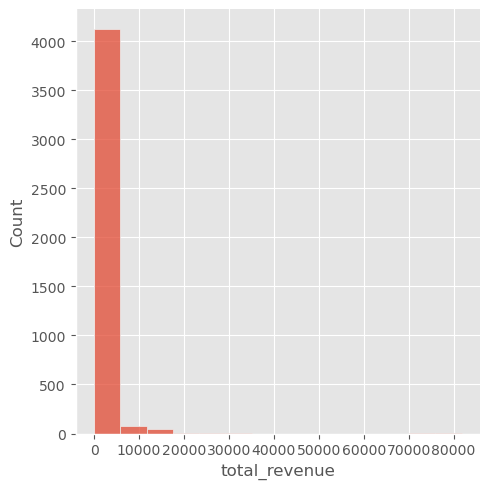

In [23]:
sns.displot(u_1.total_revenue)
sns.displot(u_2.total_revenue)

As we can see, the distributions are very distorted, non-normal, and have a significant right skew due to the presence of outliers. Because of this, the t-test is unlikely to be suitable as a statistical estimator. Therefore, to compare our control groups, we will use the non-parametric Mann-Whitney method.

  0%|          | 0/1000 [00:00<?, ?it/s]

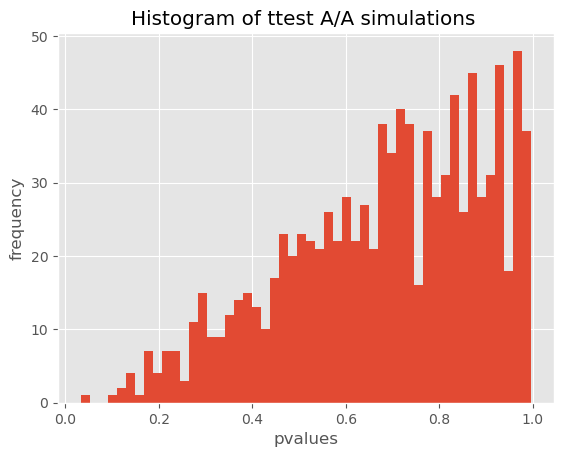

0.001

In [24]:
simulations = 1000
n_s = 3000
res = []


# Run A/A test simulations
for i in tqdm(range(simulations)):
    s1 = u_1.total_revenue.sample(n_s, replace = False)
    s2 = u_2.total_revenue.sample(n_s, replace = False)
    res.append(stats.mannwhitneyu(s1, s2)[1]) # save p-value

plt.hist(res, bins = 50)
plt.xlabel('pvalues')
plt.ylabel('frequency')
plt.title("Histogram of ttest A/A simulations ")
plt.show()

sum(np.array(res) <0.05) / simulations

The A/A test for ARPU passed correctly. FPR < less than the specified level 0.05.

Let's move on to conversion

We only charge purchases of regular premium subscriptions for conversions. To calculate such a conversion, we need to slightly transform the data. Let's add a column that will indicate whether the user has signed up for a premium subscription without taking into account the trial version.

In [25]:
t_1['premium_no_trial'] = np.where(t_1['product_type'] == 'premium_no_trial', 1, 0)
t_11 = t_1.query('product_type == "premium_no_trial"').drop_duplicates(subset=['uid'])
u_1 = u_1.merge(t_11[['uid','premium_no_trial']], on='uid', how = 'left')
u_1 = u_1.fillna(0)
u_1['premium_no_trial'] = u_1['premium_no_trial'].astype(int)

t_2['premium_no_trial'] = np.where(t_2['product_type'] == 'premium_no_trial', 1, 0)
t_22 = t_2.query('product_type == "premium_no_trial"').drop_duplicates(subset=['uid'])
u_2 = u_2.merge(t_22[['uid','premium_no_trial']], on='uid', how = 'left')
u_2 = u_2.fillna(0)
u_2['premium_no_trial'] = u_2['premium_no_trial'].astype(int)

t_test['premium_no_trial'] = np.where(t_test['product_type'] == 'premium_no_trial', 1, 0)
t_tt = t_test.query('product_type == "premium_no_trial"').drop_duplicates(subset=['uid'])
u_test = u_test.merge(t_tt[['uid','premium_no_trial']], on='uid', how = 'left')
u_test = u_test.fillna(0)
u_test['premium_no_trial'] = u_test['premium_no_trial'].astype(int)

Conversion is a categorical variable - this means we can use the chi-square test to test the difference in conversions between two control groups.

  0%|          | 0/1000 [00:00<?, ?it/s]

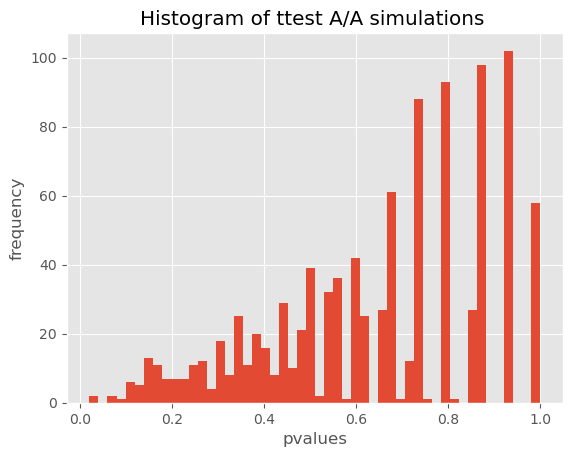

0.002

In [26]:
simulations = 1000
n_s = 3000
res = []


# Run A/A test simulations
for i in tqdm(range(simulations)):    
    s1 = u_1.premium_no_trial.sample(n_s, replace = False)
    s2 = u_2.premium_no_trial.sample(n_s, replace = False)
    a_premium = s1.sum()
    a_nopremium = s1.size - s1.sum()
    b_premium = s2.sum()
    b_nopremium = s2.size - s2.sum()
    T = np.array([[a_premium, a_nopremium], [b_premium, b_nopremium]])
    res.append(stats.chi2_contingency(T,correction=False)[1]) # save p-value

plt.hist(res, bins = 50)
plt.xlabel('pvalues')
plt.ylabel('frequency')
plt.title("Histogram of ttest A/A simulations ")
plt.show()

sum(np.array(res) <0.05) / simulations

FPR < 0.05, everything is fine.

## A/A test results:

* According to our key business metrics, the split system worked well. There is no statistical difference in ARPU or conversion between our control groups.

## A/B test to check the success of the experiment

Let's define key metrics to verify the success of the experiment. Let's take the same metrics as for the A/A test: ARPU and conversion to premium subscriptions.

Let's start with ARPU.

Let's take a look at the distribution of revenue by user.

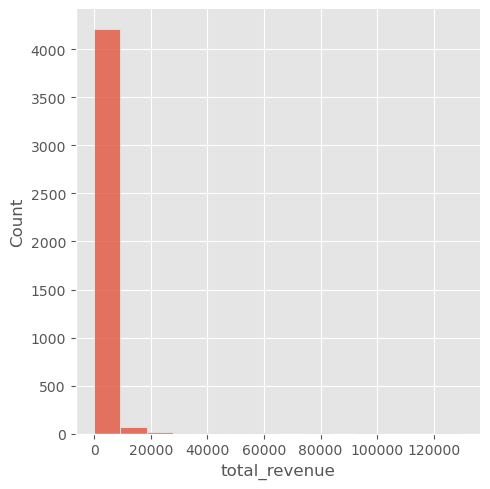

In [27]:
sns.displot(u_test.total_revenue)

Just as in the control groups, the majority of users are on the left side of the graph, or more precisely, at zero, since the vast majority of users did not make a single purchase.

For ease of analysis, we transform this data. First, let's combine our control groups. Let’s add one to the revenue of each user and perform a logarithm,
to smooth out the distribution and bring it closer to normal.

In [28]:
u_control = pd.concat([u_1, u_2])

In [29]:
u_test['log_revenue'] = np.log(u_test.total_revenue+1)
u_control['log_revenue'] = np.log(u_control.total_revenue+1)

Let's compare the average values ​​of logarithmic revenue between the test and control groups. To do this, we use Welch’s t-test to exclude the condition on the difference in variances.

In [30]:
stats.ttest_ind(u_test.log_revenue, u_control.log_revenue, equal_var=False)

TtestResult(statistic=-2.5169793011763764, pvalue=0.01185312647594008, df=9372.80679844489)

The p-value is less than the standard level of significance at 0.05, which means that the means in our groups differ significantly. However, what does this specifically mean? Let's look at the original means:

In [31]:
print(u_test.total_revenue.mean(), u_control.total_revenue.mean(), sep='\n')

544.3131383472609
526.7863535975822


We see that the mean in the test group is higher than in the control group. It's worth noting that the actual mean values are heavily distorted by the presence of a large number of zero values.

Let's take a look at the overall conversion. To do this, we'll calculate the number of users who made at least one purchase and divide this number by the total number of users.

In [32]:
print('Number of users without purchases in the test group:', u_test[u_test.total_revenue ==0].shape[0])
print('Total number of users in the test group:', u_test.shape[0])
print('Сonversion:', round(u_test[u_test.total_revenue >0].shape[0]/u_test.shape[0]*100,1),'%')
print('Number of users without purchases in the control group:', u_control[u_control.total_revenue ==0].shape[0])
print('Total number of users in the control group:', u_control.shape[0])
print('Conversion:', round(u_control[u_control.total_revenue >0].shape[0]/u_control.shape[0]*100,1),'%')


Number of users without purchases in the test group: 4162
Total number of users in the test group: 4308
Сonversion: 3.4 %
Number of users without purchases in the control group: 8224
Total number of users in the control group: 8603
Conversion: 4.4 %


In [33]:
print((u_test[u_test.total_revenue >0].shape[0]/u_test.shape[0])*u_test.total_revenue.mean(), 
      (u_control[u_control.total_revenue >0].shape[0]/u_control.shape[0])*u_control.total_revenue.mean())                                  

18.44700979542713 23.207256539984154


By calculating the expected revenue, we can see that the expected value for the test group is lower than for the control group, despite the fact that the ARPU for the test group was higher. This is all due to the fact that the conversion rate in the test group is significantly lower than in the control group.

In [34]:
print(u_test.log_revenue.mean(), u_control.log_revenue.mean(), sep='\n')

0.3153806788752927
0.39757506306745943


Looking at the averages of the logarithmic values, we also see that the mean of the test group is lower than the means of the control group.

**Summing up**: The t-test showed statistical differences between revenue in the test and control groups. However, these differences are negative, not positive, which means that our experiment had a negative impact on ARPU and future revenue

Let's turn to the second metric we chose: premium subscription conversions. To calculate the differences between conversions, we will use chi-square.

In [35]:
s1 = u_test.premium_no_trial
s2 = u_control.premium_no_trial
a_premium = s1.sum()
a_nopremium = s1.size - s1.sum()
b_premium = s2.sum()
b_nopremium = s2.size - s2.sum()
T = np.array([[a_premium, a_nopremium], [b_premium, b_nopremium]])
chi2, p, dof, expected = stats.chi2_contingency(T,correction=False)
p

0.003329986397413256

P-value < our significance level, indicating significant differences. Now let's calculate the conversion:

In [36]:
a_premium = a_premium / (a_premium + a_nopremium)
b_premium = b_premium / (b_premium + b_nopremium)
print('Conversion in the test group:', round(a_premium, 3), ', conversion in the control group', round(b_premium, 3))

Conversion in the test group: 0.016 , conversion in the control group 0.023


We see that conversion has decreased significantly.

# A/B test results

We conducted A/B testing to compare two key metrics after the experiment: ARPU and conversion to premium subscription. Although statistical tests showed significant differences between the test and control groups, we see that these are negative differences: ARPU did not grow as much as to compensate for the drop in conversions, conversions to premium subscriptions also fell. The experiment can be considered a failure.

Let's try to analyze whether the innovation makes sense among any specific user groups.

Let's take gender. For comparison, we will use the Welsh criterion.

In [40]:
a4 = u_test[u_test.gender == 0].log_revenue
a5 = u_control[u_control.gender == 0].log_revenue
stats.ttest_ind(a4,a5, equal_var=False)

TtestResult(statistic=-1.611486476012376, pvalue=0.1076357088685938, df=561.4519090612969)

In [38]:
a4 = u_test[u_test.gender == 1].log_revenue
a5 = u_control[u_control.gender == 1].log_revenue
stats.ttest_ind(a4,a5, equal_var=False)

TtestResult(statistic=-2.294309397220904, pvalue=0.02179601482481449, df=8859.276960794903)

In [39]:
print(u_test[u_test.gender == 1].log_revenue.mean(), 
      u_control[u_control.gender == 1].log_revenue.mean())

0.32626319794597464 0.403977860572328


For gender 0 there is no statistical difference, for gender 1 there is a difference between the test and control group, however if we look again at the logarithmized means we see that the test group values are less than the control group.

Since the number of conversions to premium subscription for gender 0 is zero in the test group,
analyzing conversion by gender groups does not make sense.

## Experiment Summary

Based on the results of the repeated A/B testing, the experiment can be deemed **unsuccessful**: the conversion rate significantly decreased, and while the nominal ARPU increased, the expected revenue and logarithmic ARPU values for the test group turned out to be the lowest. All of this will ultimately lead to a decrease in revenue.